# Mathing Diversity in the Modern Magic Meta

Happy Thanksgiving everyone! My name's Dylan. I've been a long time Magic: The Gathering player (Ice Age anyone?), I work as a Data Scientist for a gaming company and I had some free time this Thanksgiving...so why not try to teach myself some new techniques while trying to answer a rather elusive question: How diverse is a format in Magic: The Gathering?

To start we need to pick a format and download some decks. I'm going to stick with modern because of its 'purported' diversity and https://www.mtggoldfish.com/metagame/modern#online because they have some really good metadata (data around stuff besides the cards themselves). Now our job should be easy right? We count up all the deck names from the past 2 weeks, make a distribution, calculate some little number and feel good...well there's a couple problems with deck names.

1) They're completely hand-labeled. Is Dredge (https://www.mtggoldfish.com/deck/516731#online) a complete different deck than (https://www.mtggoldfish.com/deck/514963#online)? If all decks look like variations on this theme would that constitute a diverse meta game?

2) We can't label decks by the content of their cards. Well we could. But if you took a Jund Deck and added one more Swamp, with this method it would be an entirely new deck. Well that doesn't make sense.

3) Fringe decks muddle with the concept of diversity. This is a strange argument I'll grant you, but imagine we're in an area of strong experimentation (say a month after a major unbanning). We'd think the format was diverse, but in reality the format hadn't settled yet. We wouldn't have common archetypes and 'too much diversity' blurs any understanding of a meta. Is there even a solution for this?

There is a solution and it lies in an area of machine learning known as unsupervised learning (https://en.wikipedia.org/wiki/Unsupervised_learning). As opposed to supervised learning that tries to predict the likelihood of a defined event (like your credit card rating that predicts your likelihood to default), unsupervised learning looks for underlying patterns; hidden structure from unlabeled data. Using a specific method (fuzzy c-means https://en.wikipedia.org/wiki/Fuzzy_clustering#Fuzzy_C-means_Clustering) we'll find clusters of cards that make up decks (the meta itself), identify these cluster and fringe decks and then use some simple stats to calculate the diversity of the meta.

This post will cover the code used to run this clustering analysis R. The audience here (you) is hopefully more general that some of my previous articles, so I'm going to be a bit hand-wavy with some of the more subtler nuances in the mathy bits. If any of you out there are data scientists yourself, please don't beat me over the head for casually swapping between terms like clusters and archetypes (yes I know those are technically quite different). That said, if you have more technical questions feel free to reach out to me!

First let's load some packages!

Side note: I also wrote a little webscraper which downloads all relevant decks (mainboard only), and then used a text mining package to process them and turn them into something usable. That part is rather straightforward and frankly boring so I'll skip to the good stuff.

In [136]:
#Word Cloud Visualization
library(wordcloud)
#Calculating Diversity
library(ineq)
#Fuzzy Clustering Package
library(cluster)
#Elbow Plots to Pick Number of Cluster K
library(GMD)
#Common Visualization Library
library(ggplot2)

# Modern Today - Dredge Leads Diversity

To begin, we start by loading our November dataset of 345 decks. We've recorded the event the decks came from, the number of cards in it, the deckname itself and the deckID (in case we want to view the webpage).

In [139]:
#Let's start by loading decks from the two weeks leading up to 11/23/16 Happy Thanksgiving!

datNovModern <- read.csv(paste(pathNovModern,"FullDataset.csv", sep = ""))

datModel <- datNovModern[,5:ncol(datNovModern)]
print("The data we're starting with")
head(datNovModern[,2:10])

[1] "The data we're starting with"


,deckID,tourney,decknames2,abruptdecay,academyruins,adarkarwastes,adnauseam,aetherfluxreservoir,aetherhub
1,506098,modern-1k-lakeland-florida,Blitzkrieg (BR Control),0,0,0,0,0,0
2,506099,modern-1k-lakeland-florida,Abzan Blink,0,0,0,0,0,0
3,506100,modern-1k-lakeland-florida,Skred Red,0,0,0,0,0,0
4,506101,modern-1k-lakeland-florida,Monowhite Death & Taxes,0,0,0,0,0,0
5,506102,modern-1k-lakeland-florida,Kiki-Chord,0,0,0,0,0,0
6,506103,modern-1k-lakeland-florida,Dredge,0,0,0,0,0,0


### A Map of Deck Names

Let's use a wordcloud to visualize the decknames being used right now in Modern. It might be hard to spot, but Infect is actually the most common deck name at '8.3% of the meta', according to mtggoldfish. As mentioned before this is a little bit deceptive because we know that Dredge and Wubrg are nearly the same deck. Maybe combined they're more common than Infect?

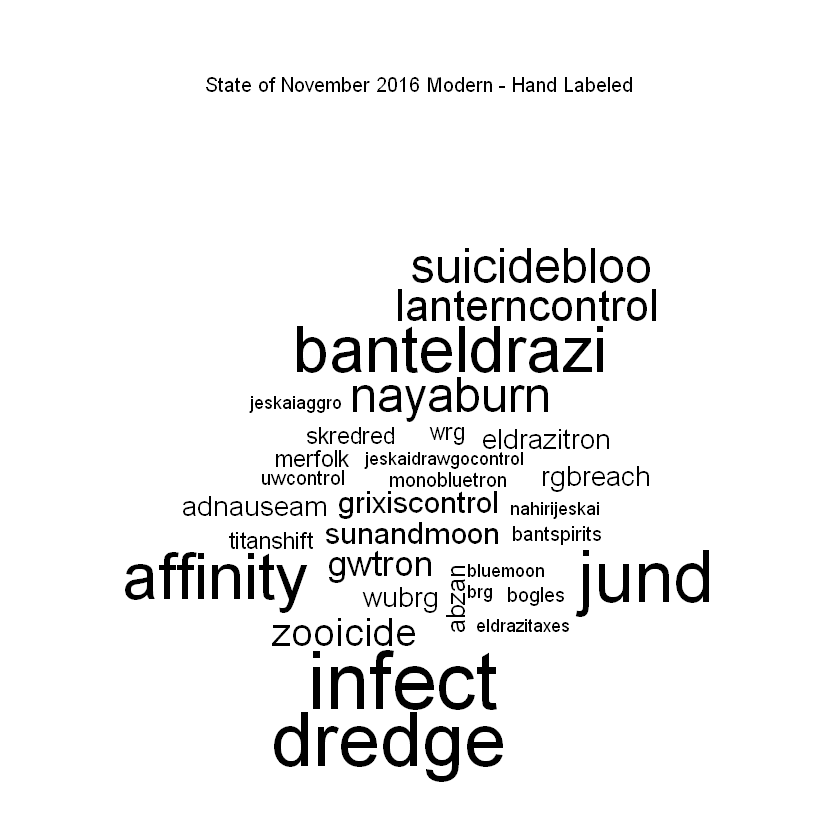

In [53]:
layout(matrix(c(1, 2), nrow=2), heights=c(1, 4))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, "State of November 2016 Modern - Hand Labeled")
wordcloud(as.character(gsub(" ", "",datNovModern$decknames2)), main = "State of November 2016 Modern - Hand Labeled")

### Begin the Clustering!

Now we're stepping into some hard math. Here we use a combination of Hierarchical Clustering and Elbow Plots to get an idea of a 'good' number of clusters (k). Picking the right number of clusters relies on some tinkering and real understanding of how the data works. To be completely honest I spent a good deal of time here and on the results finding out what jives will with our understanding and what works and what doesn't. This process of adapting new machine learning models to new situations and problem sets is what makes up the bulk of research in machine learning. Also, we're very lucky to have a hand labeled dataset to guide our intuition! All of that said we'll start with what the elbow plot suggests (k = 20 clusters).

Below you can also see a dendrogram which, while looking quite messy actually tells us that there's a great deal of difference between the decks we're considering. Going from top to bottom you can see it starts splitting quite early and the earlier splits happen the more different everything is. Feel free to compare to this example where the splits take longer to happen (scanning from top to bottom): https://www.mathworks.com/help/stats/dendrogram_default.png.

$k
[1] 20

$ev
[1] 0.7505043

$inc.thres
[1] 0.01

$ev.thres
[1] 0.75

attr(,"description")
[1] "A \"good\" k=20 (EV=0.75) is detected when the EV is no less than 0.75\nand the increment of EV is no more than 0.01 for a bigger k.\n"
attr(,"class")
[1] "elbow" "list" 


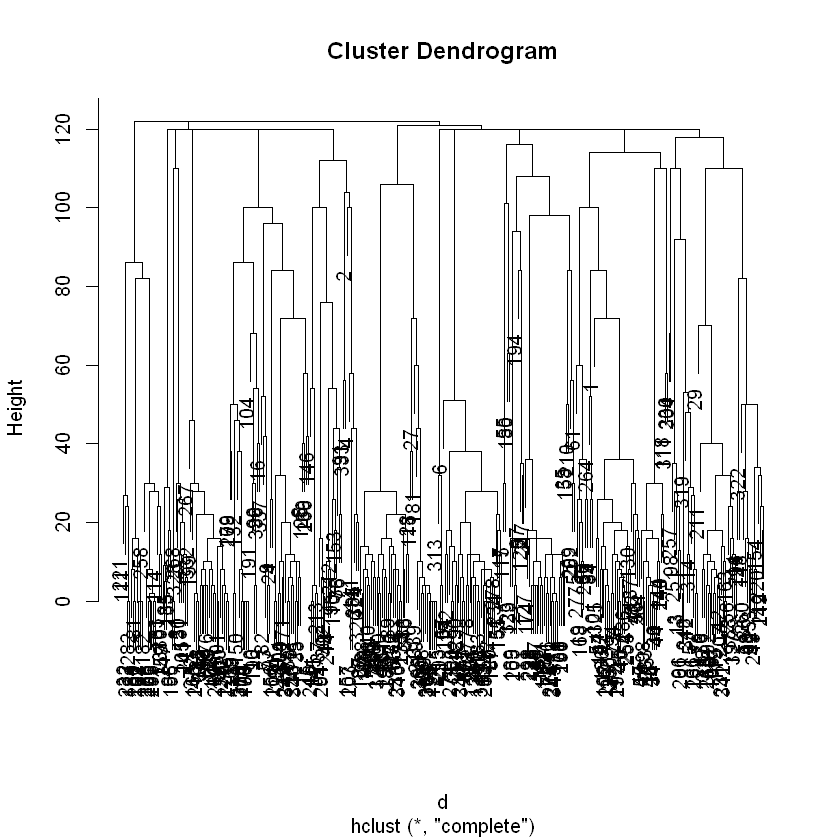

In [11]:
#Compute manhattan distance between decks
d <- dist(datModel, method = "manhattan")
#Create a hierarchical clustering model
fit <- hclust(d, method="complete") 
#Plot Results
plot(fit)

#Using hierarchical clustering and elbow plots to get an idea of a proper number of clusters
css.obj <- css.hclust(d,fit)
elbow.obj <- elbow.batch(css.obj)
print(elbow.obj)


Now we'll apply Fuzzy C-Means Clustering to our decks, which creates 20 clusters or 'Archetypes' that our decks can belong to. One cool aspect of Fuzzy Clustering is that decks are written in stone as members of a cluster. Instead they have a degree of 'membership' to all clusters. Looking at the results we can see that the Skred Red deck that performed well in Lakeland (row 3) has a very strong affinity to cluster 1 with a score of 92/100. Cluster 1 will probably be the Skred cluster.

In [168]:
#Applying Fuzzy CMeans
fuzzyClustModernNov <- fanny(datModel, k = 20, memb.exp = 1.2, metric = 'manhattan')

head(cbind(datNovModern[,3:4],round(fuzzyClustModernNov$membership*100)),8)

,tourney,decknames2,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
1,modern-1k-lakeland-florida,Blitzkrieg (BR Control),29,5,6,2,1,2,6,1,...,7,1,1,2,2,3,3,1,1,1
2,modern-1k-lakeland-florida,Abzan Blink,19,24,18,1,2,2,3,1,...,8,1,1,1,2,7,3,2,1,1
3,modern-1k-lakeland-florida,Skred Red,92,1,2,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
4,modern-1k-lakeland-florida,Monowhite Death & Taxes,9,8,69,0,1,1,1,0,...,2,0,0,0,1,3,1,1,0,1
5,modern-1k-lakeland-florida,Kiki-Chord,10,67,5,1,1,1,1,0,...,4,0,0,1,2,2,1,1,1,0
6,modern-1k-lakeland-florida,Dredge,5,3,3,79,0,1,1,0,...,1,0,0,0,1,1,1,0,0,0
7,modern-1k-lakeland-florida,Bant Eldrazi,0,0,0,0,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,modern-1k-lakeland-florida,UR Delver,14,2,3,0,0,51,17,0,...,1,1,0,1,1,4,1,0,0,0


### Indentifying Fringe Decks

Now let's talk about Abzan Blink (row 2). It doesn't have a strong affinity to any of the clusters. Does this mean that it isn't part of the meta game? Mathematically? No. It's not common enough in play to form it's own identity, but it did come out of nowhere and place well in lakeland. Fringe decks like these are good to look to see what's coming up on the horizon (and what's falling off).

Getting back to the math, in order to be considered part of the meta we only look for decks that have at 50% or greater membership in any one cluster. Sorry Abzan Blink. You're out!

For those that were sad to see Abzan Blink get booted for the cool meta club feel free to check out him and his(her?) friends in the appendix.

In [140]:
goodCandidatesModernNov <- apply(fuzzyClustModernNov$membership,1,FUN = max) > .5

### Vizualizing the Meta in November

Now that we've cut out the fringe decks let's look at the face of the modern meta right now.

First we can list the names of every deck in a cluster. For some clusters we see very tight grouping. Cluster 10 is only Jund. For others like cluster 2 we see a looser affliation of decks, but based around similar cards. For cluster 2, path to exile, collected company and a bit of the land-base bring these decks together (visualzation in the appendix).

In [141]:

fuzzyClustPlot <- data.frame(deckname = datNovModern$decknames2 , cluster = fuzzyClustModernNov$clustering,aggCol = 1)[goodCandidatesModernNov,]
p2 <- aggregate(aggCol ~ deckname + cluster,data = fuzzyClustPlot, FUN = sum)
p2

,deckname,cluster,aggCol
1,Skred Red,1,5
2,Abzan Company,2,1
3,Bant Spirits,2,4
4,Bogles,2,4
5,Kiki-Chord,2,2
6,Kiki Evolution,2,1
7,Knightfall,2,2
8,Naya Company,2,1
9,Eldrazi & Taxes,3,3
10,Merfolk,3,5


Visualizing the above table into bar graph form we can see the biggest cluster is 4 (Dredge + WUBRG). Some clusters are composed only of single deck names, while others are a hotbed of variation. My best guess at cluster 2 is Selesnya Chord and cluster 16 seems to be several variants of Jeskai Control.

This is great! We got what we wanted. Decks are now clumped by similar cards, but not constrained by whatever names we're calling them. We also identify decks outside the metagame and choose to treat them differently.

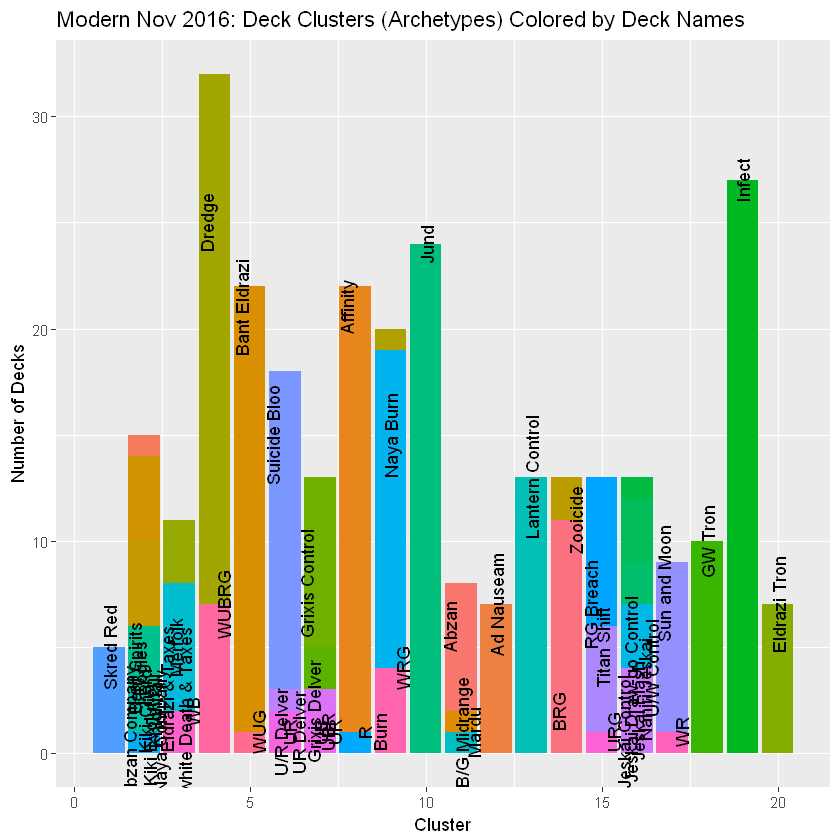

In [142]:
ggplot(p2, aes(cluster, aggCol, fill = deckname)) + geom_bar(stat = "Identity") + guides(fill = FALSE) +
 labs(title = "Modern Nov 2016: Deck Clusters (Archetypes) Colored by Deck Names", x = "Cluster", y = "Number of Decks") +
geom_text(aes(x=cluster, y=aggCol, label=deckname), 
           position = position_dodge(width=1), angle = 90)

### Calculating Diversity

After this affair, diversity is a rather simple calculation. Let's view it in three different ways. First we can see how much the most common deck (Dredge NOT Infect) dominates the format, as well as our clusters (or Archetypes). We can also calculate the minimum number of decks it would take to account for 50% of the meta. Right now in Modern, 8 decks cover around 50% of the format (Dredge, Infect, Jund, Affinity, Bant Eldrazi, Burn Variants, Suicide Bloo and Company Decks).

Also we held off classifying some decks because they were too far from the bulk of other decks being played. These fringe decks currently only populate 12.5% of the meta.

Finally if we go for something based in a bit more math we can calculate diversity using a Gini coefficient (https://en.wikipedia.org/wiki/Gini_coefficient). This number calculates the inequality in a distribution and was originially proposed as a measure of income inequality in countries. The coefficient itself ranges from 0 (perfectly equal number of decks in every cluster) to 1 (all decks in a single cluster, none in any other).

Right now the modern meta stands at a Gini Index of 0.159! Which means almost nothing without context. Let's look at Modern when I first had some free time to pull some data, 6 months ago in May!

In [166]:
#Diversity Score!

#Drege - New
print("What Percent of the Field Overall Do Dredge Decks Cover?")
sum(fuzzyClustModernNov$clustering == 4)/length(fuzzyClustModernNov$clustering)*100
print("What Percent of Known Archetypes Do Dredge Decks Cover?")
max(table(fuzzyClustModernNov$clustering[goodCandidatesModernNov]))/length(fuzzyClustModernNov$clustering[goodCandidatesModernNov])*100
print("How Many Decks Does it Take to Occupy 50% of The Meta?")
tx <- table(fuzzyClustModernNov$clustering[goodCandidatesModernNov])/length(fuzzyClustModernNov$clustering)
sum(cumsum(tx[order(-tx)]) < 0.5) + 1
print("Percentage of the Meta Composed of Unclassified (Fringe) Decks")
sum(goodCandidatesModernNov == FALSE)/length(goodCandidatesModernNov)*100
print("Measure of Diversity for Top 10 Most Common Archetypes of the Format")
topdecks <- table(fuzzyClustModernNov$clustering[goodCandidatesModernNov])[order(-table(fuzzyClustModernNov$clustering[goodCandidatesModernNov]))[1:10]]
ineq(topdecks,type = "Gini")

[1] "What Percent of the Field Overall Do Dredge Decks Cover?"


[1] 9.275362

[1] "What Percent of Known Archetypes Do Dredge Decks Cover?"


[1] 10.59603

[1] "How Many Decks Does it Take to Occupy 50% of The Meta?"


[1] 8

[1] "Percentage of the Meta Composed of Unclassified (Fringe) Decks"


[1] 12.46377

[1] "Measure of Diversity for Top 10 Most Common Archetypes of the Format"


[1] 0.1592233

# Modern in May 2016 - The Reign of Jund?

May was a tumultuous time for Modern. It was only a month after unbanning/banning some serious cards (http://magic.wizards.com/en/articles/archive/news/banned-and-restricted-announcement-2016-04-04). Let's go ahead and perform the same analysis on this data and see if any patterns arise. Is Modern in May more or less of a diverse format?

In [70]:
#Let's compare to older timeframes by loading decks from the two weeks leading up to 5/18/16!

datMayModern <- read.csv(paste(pathMayModern,"FullDataset.csv", sep = ""))

datModel2 <- datMayModern[,5:ncol(datMayModern)]

### Modern Decks In May

Looking at this wordcloud we see that Jund, RGTron and Infect immediately leap to mind. But does this bear out in our clustering model?

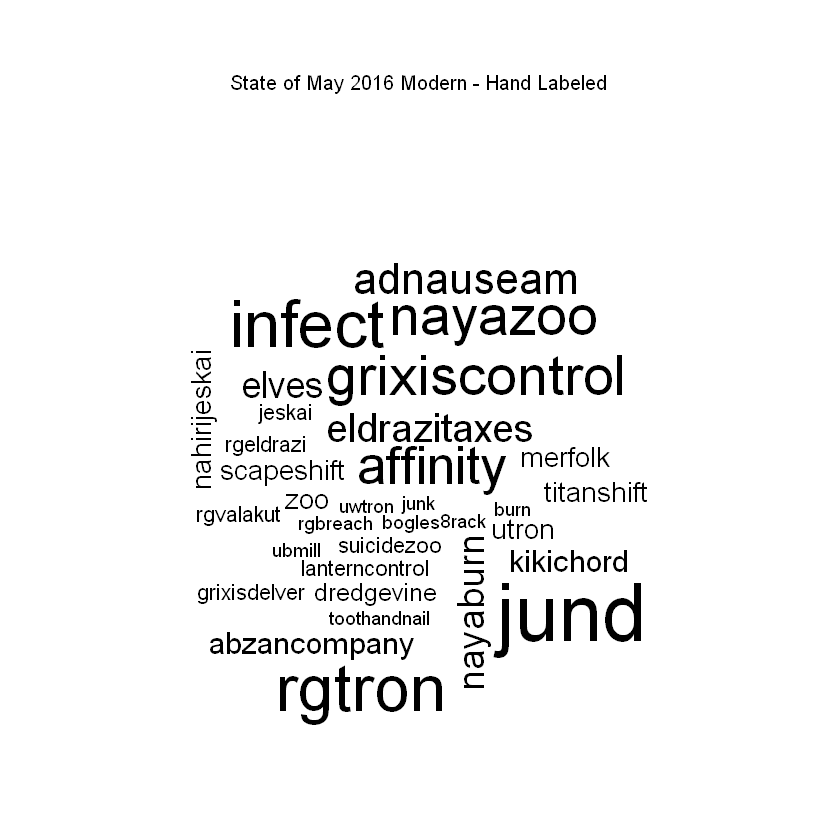

In [71]:
layout(matrix(c(1, 2), nrow=2), heights=c(1, 4))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, "State of May 2016 Modern - Hand Labeled")
wordcloud(as.character(gsub(" ", "",datMayModern$decknames2)), main = "State of November 2016 Modern - Hand Labeled")

### Clustering Yet Again!

This time when calculating the preferred number of clusters we get something slightly lower (17). This suggests that perhaps there's less diversity. The real story is a bit more complicated.

In [73]:
#Compute manhattan distance between decks
d <- dist(datModel2, method = "manhattan")
fit <- hclust(d, method="complete") 

#Using hierarchical clustering and elbow plots to get an idea of a proper number of clusters
css.obj <- css.hclust(d,fit)
elbow.obj <- elbow.batch(css.obj)
print(elbow.obj)

$k
[1] 17

$ev
[1] 0.6826971

$inc.thres
[1] 0.01

$ev.thres
[1] 0.67

attr(,"description")
[1] "A \"good\" k=17 (EV=0.68) is detected when the EV is no less than 0.67\nand the increment of EV is no more than 0.01 for a bigger k.\n"
attr(,"class")
[1] "elbow" "list" 


### The Technical Reason We Went With Lower Clusters (Feel Free to Skip This)

Here we went with 15 clusters as opposed to our original 17. The reason for this is buried in the details of how fuzzy c-mean works. After the fuzzy model runs it checks to see if there are any clusters which have no strong memberships to any other decks. These clusters don't describe any deck in particular. They're usually just a mishmash of common cards used in a big grouping of decks. After the model is done it counts the number of clusters that DO have strong membership and ignore those that don't. This number of 'crisp' clusters is called 'k.crisp'.

If our k.crisp is larger than our original number of cluster k, we should reduce it to the number suggested and run it again (and so we did).

In [169]:
#Build the May Model (Tinkered with some hyperparameters)
fuzzyClustModernMay <- fanny(datModel2, k = 15, memb.exp = 1.2, metric = 'manhattan', maxit = 1000)
print("We check that this value agrees with our number of clusters")
fuzzyClustModernMay$k.crisp
#Filter for Decks that have a good clustering
goodCandidatesModernMay <- apply(fuzzyClustModernMay$membership,1,FUN = max) > .5
print("Our clusters and membership as before")
head(cbind(datMayModern[,3:4],round(fuzzyClustModernMay$membership*100)),8)

[1] "We check that this value agrees with our number of clusters"


[1] 15

[1] "Our clusters and membership as before"


,tourney,decknames2,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,modern-league-2016-05-05,Naya Burn,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,modern-league-2016-05-05,Through the Breach,1,51,1,8,1,0,3,0,23,1,0,1,9,0,1
3,modern-league-2016-05-05,Ad Nauseam,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0
4,modern-league-2016-05-05,RG,1,3,1,45,5,1,3,1,3,1,1,1,30,1,2
5,modern-league-2016-05-05,Goblins,4,5,1,35,3,1,5,1,5,1,1,8,27,1,1
6,modern-league-2016-05-05,Kiki Chord,0,0,0,1,98,0,0,0,0,0,0,0,0,0,0
7,modern-league-2016-05-05,Naya Burn,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,modern-league-2016-05-05,Dredgevine,2,3,2,44,4,1,3,1,5,4,2,2,24,1,2


### Visualizing The Meta in May

Again we list the decks available by cluster to get an idea of cluster composition. You'll notice that cluster 4 was left our entirely! This happened because even after passing our k.crisp test above, cluster 4 didn't have a single deck with over 50% membership. It really was a cluster full of a smattering of cards mostly centered around lightning bolt (check out the appendix).

In [155]:
fuzzyClustPlot2 <- data.frame(deckname = datMayModern$decknames2 , cluster = fuzzyClustModernMay$clustering,aggCol = 1)[goodCandidatesModernMay,]
p3 <- aggregate(aggCol ~ deckname + cluster,data = fuzzyClustPlot2, FUN = sum)
p3

,deckname,cluster,aggCol
1,Burn,1,3
2,Naya Burn,1,9
3,4-Color Bring To Light,2,1
4,Blue Moon,2,1
5,Jeskai,2,4
6,Jeskai Control,2,2
7,Nahiri Jeskai,2,6
8,Temur Midrange,2,1
9,Through the Breach,2,1
10,Ad Nauseam,3,11


Visualizing the above table into bar graph form we can see the biggest cluster is 10 (Jund with a few variants). Again some clusters stand alone (Affinity and Ad Nauseam), while others are a medley. Cluster 6 is a ton of Tron variants! Also, while we see Jund and Tron variants represented well Infect does get dwarfed a bit by Grixis Control and Delver.

So how are we on diversity?

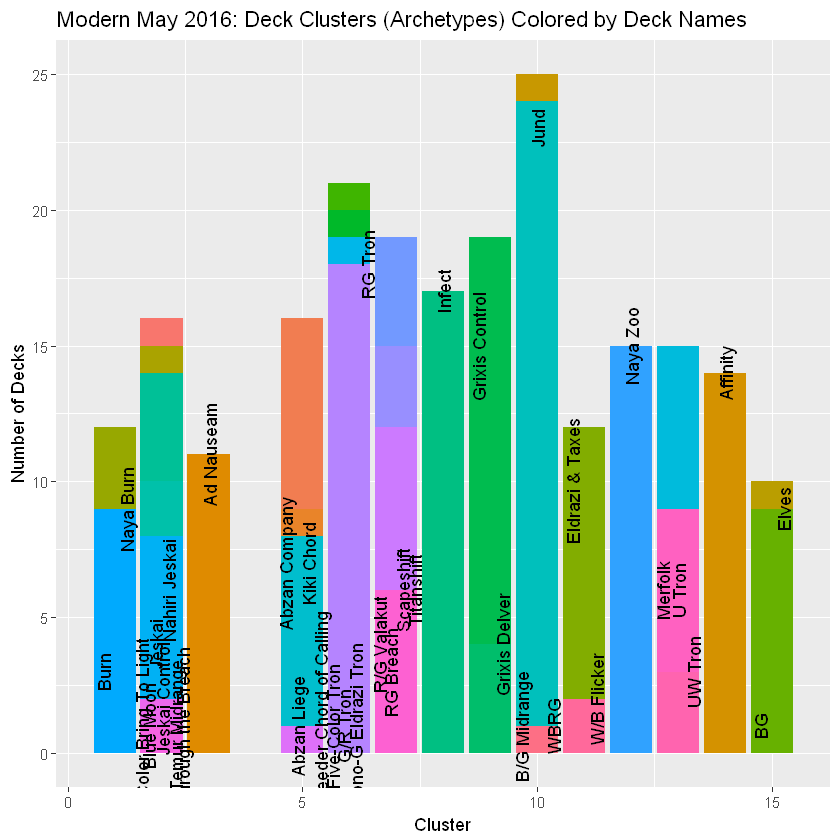

In [156]:
ggplot(p3, aes(cluster, aggCol, fill = deckname)) + geom_bar(stat = "Identity") + guides(fill = FALSE) +
 labs(title = "Modern May 2016: Deck Clusters (Archetypes) Colored by Deck Names", x = "Cluster", y = "Number of Decks") +
geom_text(aes(x=cluster, y=aggCol, label=deckname), 
           position = position_dodge(width=1), angle = 90)

### Diversity Revisited & Conclusions

Let's run the same statistics for May.

In [164]:
#Diversity Score!

#Jund - Old
print("What Percent of the Field Overall Do Jund Decks Cover?")
sum(fuzzyClustModernMay$clustering == 10)/length(fuzzyClustModernMay$clustering)*100
print("What Percent of the Known Archetypes Do Jund Decks Cover?")
max(table(fuzzyClustModernMay$clustering[goodCandidatesModernMay]))/length(fuzzyClustModernMay$clustering[goodCandidatesModernMay])*100
print("How Many Decks Does it Take to Occupy 50% of The Meta?")
tx <- table(fuzzyClustModernMay$clustering[goodCandidatesModernMay])/length(fuzzyClustModernMay$clustering)
sum(cumsum(tx[order(-tx)]) < 0.5) + 1
print("Percentage of the Meta Composed of Unclassified (Fringe) Decks")
sum(goodCandidatesModernMay == FALSE)/length(goodCandidatesModernMay)
print("Measure of Diversity for Top 10 Most Common Archetypes of the Format")
topdecks <- table(fuzzyClustModernMay$clustering[goodCandidatesModernMay])[order(-table(fuzzyClustModernMay$clustering[goodCandidatesModernMay]))[1:10]]
ineq(topdecks,type = "Gini")


[1] "What Percent of the Field Overall Do Jund Decks Cover?"


[1] 8.445946

[1] "What Percent of the Known Archetypes Do Jund Decks Cover?"


[1] 11.26126

[1] "How Many Decks Does it Take to Occupy 50% of The Meta?"


[1] 8

[1] "Percentage of the Meta Composed of Unclassified (Fringe) Decks"


[1] 0.25

[1] "Measure of Diversity for Top 10 Most Common Archetypes of the Format"


[1] 0.09661017

In May Jund (and a few Jund related variants) represented 8.4% of the meta and 11.2% of the known archetypes. Now Dredge (and WUBRG) represents 9.3% of the meta but 10.6% of the known archetypes. In both timeframes 8 decks archetypes were enough to account for half of the format. What is starkly different between the two timeframes is the percentage of fringe decks! While now we sit at roughly 12.5% fringe decks, modern in May had 25% of its decks with no identifyable archetype. This means that experimentation was rampant in May compared to now and in winter the meta has cooled down and solidifed around more decks (20 vs 15), but less experimentation.

Speaking directly to the perception of diversity one could argue Jund looked more dominant back in May because it took up a larger proportion of the percieved meta (11.2%) even though rampant experimentation was going on. Dredge by contrast occupies less of the total meta (10.6%), but that's only due to a smaller amount of experimentation. In reality Dredge stands more prevalant than Jund at 9.3% of the current meta.

These differences are surprisingly minor. We can look to the gini coefficient for both timeframes. Though we are now in a less diverse format gini coefficient of 0.159 compared to 0.097 back in May these differences are actually quite minor. For instance, look at the differences between the meta in modern now https://www.mtggoldfish.com/metagame/modern#online and the prevalence of 
the most dominant deck in standard https://www.mtggoldfish.com/metagame/standard#online (White-Blue Flash by mtggoldfish's own account is 29.23% of the meta).

Even though things have cooled down and we have less experimentation...yeah folks. We have it pretty good.

Some parting words:

I want to thank Wizards of the Coast and MTGGoldfish for all the data I was able to glean and all of you for reading this. As in all research I think there's a good deal more to do here and many things worth improving (sample size, model selection, finding a better way to pick the number of clusters). Please let me know if you have any questions or comments.

# Appendix

Fringe decks in November 2016 modern.

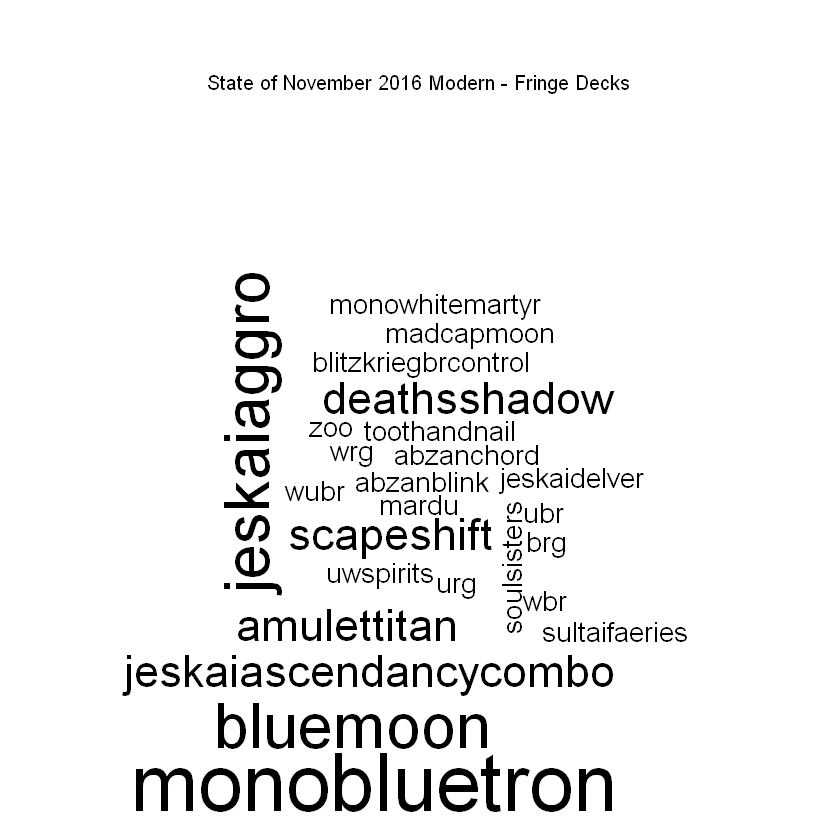

In [145]:
layout(matrix(c(1, 2), nrow=2), heights=c(1, 4))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, "State of November 2016 Modern - Fringe Decks")
wordcloud(as.character(gsub(" ", "",datNovModern$decknames2[goodCandidatesModernNov == FALSE]))
          , main = "State of November 2016 Modern - Fringe Decks",min.freq = 1)

The contents of November 2016's cluster 2. Mostly focused around path to exile, collected company and the land base.


            Abzan Blink             Abzan Chord           Abzan Company 
                      1                       1                       1 
           Bant Spirits                      BG                  Bogles 
                      4                       1                       4 
Jeskai Ascendancy Combo              Kiki-Chord          Kiki Evolution 
                      1                       2                       1 
             Knightfall            Naya Company             U/W Spirits 
                      2                       1                       1 
                    WRG                     Zoo 
                      1                       1 

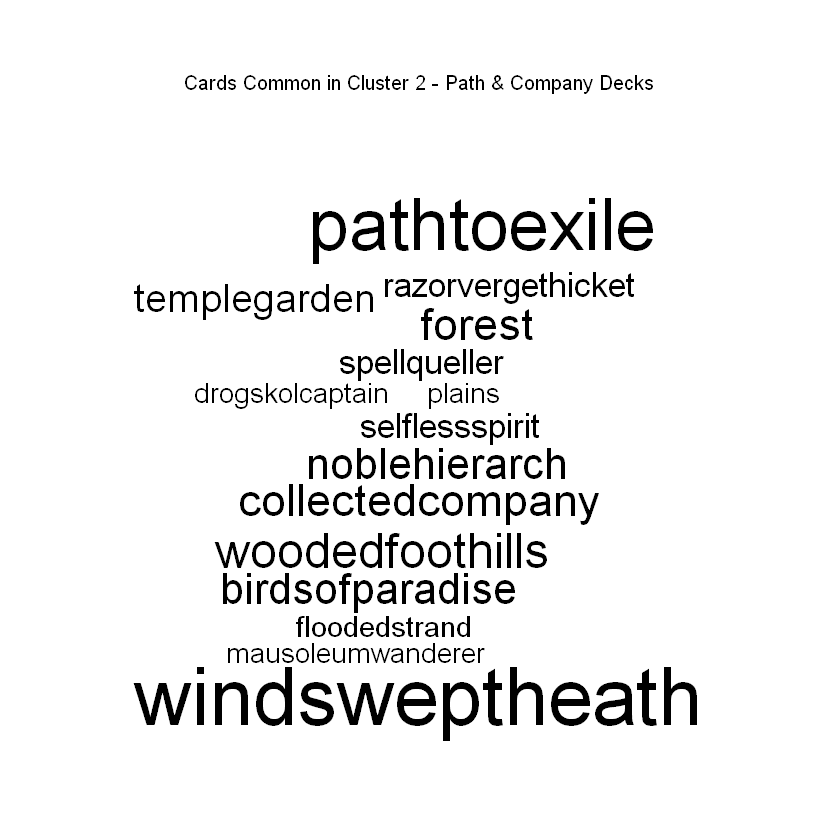

In [163]:
wordDat <- colSums(datModel[fuzzyClustModernNov$clustering == 2,])
print("Decks Common in November's Cluster 2")
table(datNovModern[fuzzyClustModernNov$clustering == 2,"decknames2"])[table(datNovModern[fuzzyClustModernNov$clustering == 2,"decknames2"]) != 0]
layout(matrix(c(1, 2), nrow=2), heights=c(1, 4))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, "Cards Common in Cluster 2 - Path & Company Decks")
wordcloud(rep(names(wordDat),wordDat), max.words = 15)

The contents of May's 'Junk' cluster. Mostly full of decks that run lightning bolts.


              8-Rack                8Rack         Bant Eldrazi 
                   2                    1                    1 
              Bogles               Dredge           Dredgevine 
                   3                    2                    5 
       Elemental Zoo G/R Land Destruction         G/W Hexproof 
                   2                    2                    1 
             Goblins    Goryo's Vengeance               Humans 
                   1                    1                    1 
                Junk      Lantern Control           Living End 
                   3                    4                    2 
               Mardu  Mardu Planeswalkers       Mono-Red Blitz 
                   1                    1                    1 
         R/G Eldrazi                   RG              Slivers 
                   3                    1                    1 
               Storm          Suicide Zoo       Tooth and Nail 
                   1                   

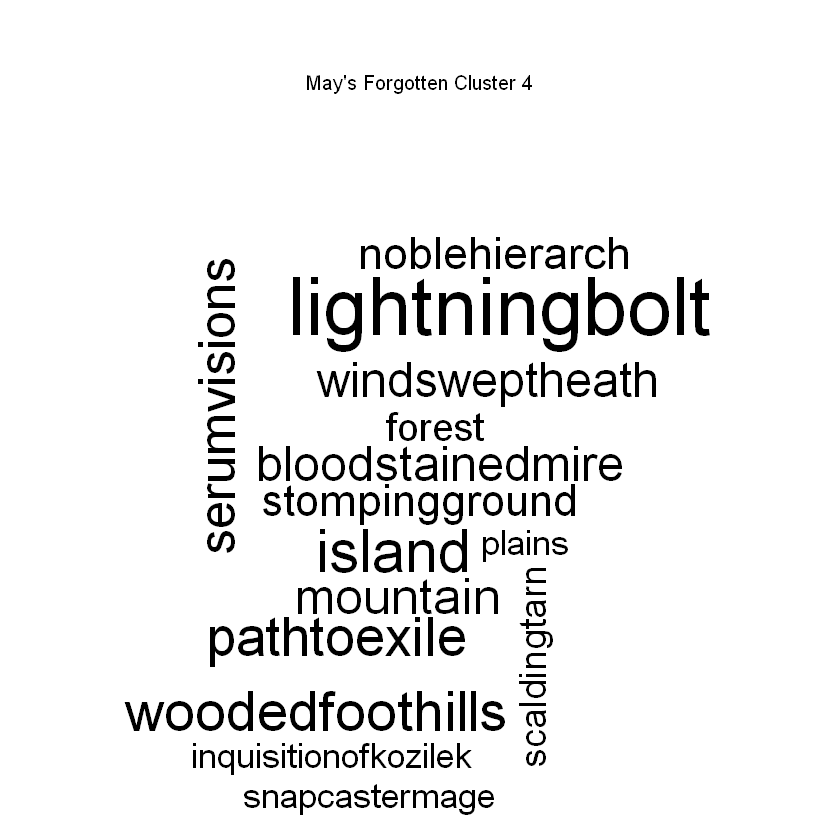

In [162]:
wordDat <- colSums(datModel[fuzzyClustModernMay$clustering == 4,])
table(datMayModern[fuzzyClustModernMay$clustering == 4,"decknames2"])[table(datMayModern[fuzzyClustModernMay$clustering == 4,"decknames2"]) != 0]
layout(matrix(c(1, 2), nrow=2), heights=c(1, 4))
par(mar=rep(0, 4))
plot.new()
text(x=0.5, y=0.5, "May's Forgotten Cluster 4")
wordcloud(rep(names(wordDat),wordDat), max.words = 15)